In [47]:
import numpy as np
from tensorflow import keras
from keras.datasets import fashion_mnist

### Завантаження датасету

In [48]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

In [49]:
print("Розмір тренувального датасету:", len(train_data))
print("Мітки тренувального датасету:", train_labels)
print("Значення мітоки: від", min(train_labels), "до", max(train_labels))
print("Розмір тестового датасету:", len(test_data))

Розмір тренувального датасету: 60000
Мітки тренувального датасету: [9 0 0 ... 3 0 5]
Значення мітоки: від 0 до 9
Розмір тестового датасету: 10000


In [50]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


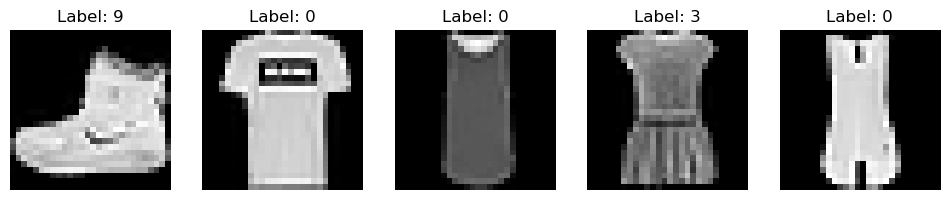

In [51]:
import tensorflow as tf
import matplotlib.pyplot as plt

num_samples = 5
plt.figure(figsize=(12, 4))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(train_data[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')

plt.show()

### Початкові значення параметрів

In [63]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 50 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів

n_hidden_1 = 256 # кількість нейронів 1-го шару
n_hidden_2 = 128 # кількість нейронів 2-го шару

In [64]:
from keras.utils import to_categorical

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(train_data, np.float32), np.array(test_data, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перетворюємо цілочисельні мітки на тип float32
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Перетворюємо мітки в категорійний формат
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

### Створюємо модель

### Конфігурація :

1. Кількість шарів - 3
2. Функція активації внутрішніх шарів - ReLU
3. Кількість нейронів 1 внутрішнього шару - 256
4. Кількість нейронів 2 внутрішнього шару - 128
5. Кількість епох - 50
6. Розмір батчу - 256
7. Оптимізатор - Adam
8. Метод регуляризації - Dropout

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import losses
from keras import metrics

from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout

# Параметри для планувальника швидкості навчання
lr_schedule = ExponentialDecay(
    learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

model = Sequential([
    Dense(n_hidden_1, activation='relu', input_shape=(num_features,)),
    Dropout(0.5),  
    Dense(n_hidden_2, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

# Використовуємо планувальник для оптимізатора
optimizer = Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [78]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705,439 (2.69 MB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 470,293 (1.79 MB)

In [67]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [68]:
def model_fit(model):
    history = model.fit(
        partial_x_train, 
        partial_y_train, 
        epochs=training_steps,
        batch_size=batch_size,
        validation_data=(x_val, y_val)
    )
    return history

In [69]:
def history_visual(history):    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5827 - loss: 1.2000 - val_accuracy: 0.8200 - val_loss: 0.4828
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8047 - loss: 0.5566 - val_accuracy: 0.8464 - val_loss: 0.4157
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8285 - loss: 0.4886 - val_accuracy: 0.8575 - val_loss: 0.3885
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8365 - loss: 0.4560 - val_accuracy: 0.8652 - val_loss: 0.3698
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8469 - loss: 0.4300 - val_accuracy: 0.8667 - val_loss: 0.3598
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8491 - loss: 0.4183 - val_accuracy: 0.8725 - val_loss: 0.3528
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8570 - loss: 0.3989 - val_accuracy: 0.8720 - val_loss: 0.3481
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8612 - loss: 0.3935 - val_accuracy: 0.

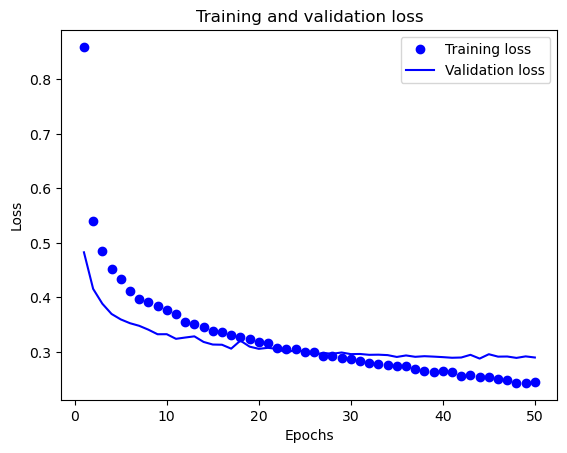

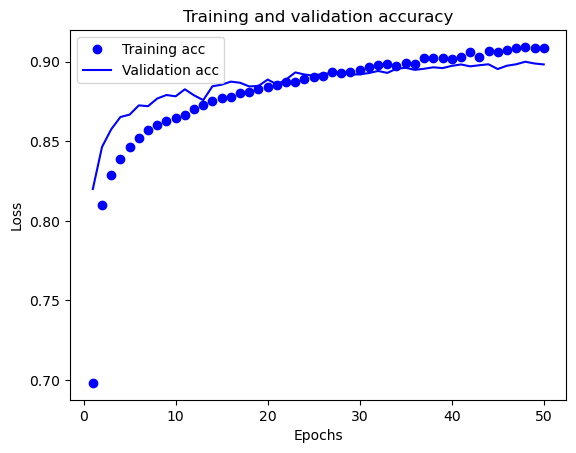

In [70]:
history = model_fit(model)
history_visual(history)

### Висновок:

Побудована модель включає регуляризатор Dropout, який випадковим чином вимикає деякі нейрони під час навчання, тим самим підвищуючи стійкість мережі. Застосування планувальника швидкості навчання дозволило покращити продуктивність моделі. Використання функції активації ReLU та оптимізатора Adam забезпечило досягнення високих результатів: точність моделі на тестових даних становить приблизно 91%, а максимальна точність на валідаційних даних склала близько 90%.

### Результати роботи моделі на тестових даних

In [72]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.8872 - loss: 0.3209
Test Loss: 0.31996095180511475
Test Accuracy: 0.8896999955177307


### Передбачення для тестових даних

In [73]:
predictions = model.predict(x_test)

print(f'Predictions for the first example: {predictions[0]}')

predicted_classes = np.argmax(predictions, axis=1)

print(f'Predicted classes for the first examples: {predicted_classes[:10]}')
print(f'Real classes for the first examples: {test_labels[:10]}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
Predictions for the first example: [3.3680863e-08 5.5688793e-07 1.1874752e-09 6.1786061e-09 3.0105732e-10
 1.4069333e-04 8.2741952e-10 7.8438397e-04 6.8396808e-09 9.9907434e-01]
Predicted classes for the first examples: [9 2 1 1 6 1 4 6 5 7]
Real classes for the first examples: [9 2 1 1 6 1 4 6 5 7]


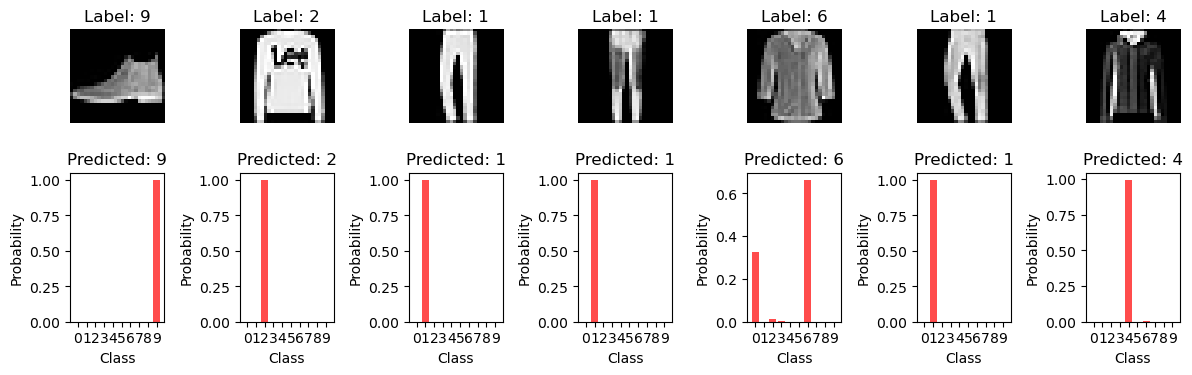

In [77]:
num_samples = 7
plt.figure(figsize=(12, 4))

for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(test_data[i], cmap='gray')  
    plt.title(f"Label: {test_labels[i]}")  
    plt.axis('off')

    plt.subplot(2, num_samples, i + num_samples + 1)
    plt.bar(range(10), predictions[i], color='red', alpha=0.7)
    plt.title(f"Predicted: {predicted_classes[i]}")
    plt.xticks(range(10))
    plt.xlabel("Class")
    plt.ylabel("Probability")

plt.tight_layout()
plt.show()